Este es el programa para realizar el análisis Exploratorio de los Datos (EDA) de cada una de las hojas de una planilla Excel. Este consta de tres partes, primero se importa todas las librerías necesarias, luego se define una función que realiza todo el análisis exploratorio y finalmente se llama a esta función con la ruta a la planilla Excel. Por lo que, para usar este programa solo hay que cambiar la ruta al archivo.
El análisis de los resultados está en el archivo "Informe_EDA_Telecomunicaciones.pdf" 

In [1]:
#Se importan todas las librerías necesarias. Si no aparece un error es porque la librería no se encuentra instalada
#para instalar una libreria en una terminal poner: pip install "nombre de la librería"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Creo la funcion para hacer el análisis correspondiente. EL mismo toma una tabla excell y realiza el análisis por cada hoja de la misma.  

In [2]:
# Función para limpieza de datos y EDA por hoja
def clean_and_explore(excel_data):
    for sheet_name in excel_data.sheet_names:
        print(f"\n--- Análisis de la hoja: {sheet_name} ---")
        df = excel_data.parse(sheet_name)

        # Busca si hay fechas en el dataset y las convierte al formato 
        for col in df.columns:
            if df[col].dtype == object:
                try:
                    df[col] = pd.to_datetime(df[col], errors='ignore')
                except Exception as e:
                    pass

        # Cantidad de valores faltantes antes de la limpieza
        missing_values_before = df.isnull().sum().sum()
        print(f"Cantidad de valores faltantes antes de la limpieza: {missing_values_before}")

        # Eliminación de duplicados
        duplicates_before = df.duplicated().sum()
        print(f"Cantidad de registros duplicados antes de la limpieza: {duplicates_before}")
        df = df.drop_duplicates()

        # Limpieza de datos: eliminar filas con datos faltantes
        df_cleaned = df.dropna()

        # Cantidad de valores eliminados
        missing_values_after = df.isnull().sum().sum()
        print(f"Cantidad de valores faltantes eliminados: {missing_values_before - missing_values_after}")

        # Conversión de tipos: numéricos y cadenas de texto
        for column in df_cleaned.columns:
            if df_cleaned[column].dtype == object:
                df_cleaned[column] = df_cleaned[column].astype(str)
            elif pd.api.types.is_numeric_dtype(df_cleaned[column]):
                df_cleaned[column] = pd.to_numeric(df_cleaned[column], errors='coerce')

        # Identificación de valores atípicos (outliers) usando el método IQR
        numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            Q1 = df_cleaned[col].quantile(0.25)
            Q3 = df_cleaned[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df_cleaned[(df_cleaned[col] < (Q1 - 1.5 * IQR)) | (df_cleaned[col] > (Q3 + 1.5 * IQR))]
            print(f"Cantidad de valores atípicos en la columna '{col}': {len(outliers)}")

            # Boxplot para visualizar outliers
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df_cleaned[col])
            plt.title(f"Boxplot para la columna {col}")
            plt.show()

        # Mostrar información básica
        print("\nResumen estadístico:\n", df_cleaned.describe(include='all'))
        print("\nTipos de datos:\n", df_cleaned.dtypes)

        # Análisis visual: distribuciones y correlaciones
        sns.pairplot(df_cleaned.select_dtypes(include=[np.number]))
        plt.suptitle(f"Distribución de variables numéricas en {sheet_name}", y=1.02)
        plt.show()

        # Correlación de variables numéricas
        plt.figure(figsize=(10, 8))
        sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm')
        plt.title(f"Mapa de calor de correlaciones para {sheet_name}")
        plt.show()

        

Explicación del código:
EL programa recibe una hoja Excel previamente transformada en un dataframe pandas. Luego va explorando cada una de las hojas del Excel (sheet_names)
Lo primero que hace es buscar si una columna corresponde a una fecha almacenada como texto y la transforma para que sea interpretada como fecha y no como cadena de caracteres. 
Luego pasa a eliminar las filas que tienen valores faltantes y filas duplicadas, y brinda la cantidad de valores nulos y duplicados encontrados y las filas eliminadas. Primero cuenta los valores nulos (.isnull) de cada columna y los valores duplicados (.duplicated). Para luego de eliminarlos (.dropna, .drop_duplicates).  
Para poder trabajar con las columnas en necesario convertirlos a números y cadena de texto. 
Para las variables numéricas se buscan los valores atípicos mediante el método de Rango Inter cuartil (IQR) Este utiliza el primer cuartil (Q1), también llamado percentil 25%, que representa el valor por debajo del cual se encuentra el 25% de los datos. El tercer cuartil  (Q3) o percentil 75%, que representa el valor por debajo del cual se encuentra el 75% de los datos. Y se calcula el rango inter cuartil: IQR=Q3−Q1, que mide la dispersión del 50% central de los datos.
Los valore atípicos son aquellos que están por debajo o por encima del límite inferior y superior respectivamente. Estos límites se calculan de la siguiente manera:
o	Límite inferior: Q1−1.5×IQR
o	Límite superior: Q3+1.5×IQR
 Además de la cantidad de valores atípicos el programa brinda un gráfico del tipo BoxPlot. Este es una manera gráfica de ver los estadísticos de los datos. Ya que se muestra los cuartiles, la mediana, el IQR y los límites superior e inferior.
Luego se muestra mediante la función .describe se muestran los estadísticos básicos. Estos son: 
count : total de los datos
mean : media o promedio de los datos.
std: desviación estándar.        
Min: valor mínimo.    
25%: primer cuartil (Q1) 
50%: segundo cuartil (Q2) Este valor también representa la mediana  
75%: tercer cuartil (Q3)    
Max: valor máximo

Mediante la función .pairplot se genera una “matriz” de gráficos en donde cada gráfico por fuera de la diagonal de la matriz representa la relación entre dos variables, este es un indicador visual de una posible correlación entre las mismas y en la diagonal principal se muestra la distribución de de cada variable.  
Además de la representación gráfica se calcula la correlación de cada par de variables mediante la función .corr, este utiliza el método de Pearson (el método por default) para calcular la correlación entre dos variables. Esta función devuelve una matriz cuyos coeficientes toman  valores que van desde -1 hasta 1, donde:

Un valor de 1 indica una correlación positiva perfecta.
Un valor de -1 indica una correlación negativa perfecta.
Un valor de 0 indica que no hay correlación lineal entre las variables.
Cuando el factor de correlación está cerca de 1 o-1 puede indicar una dependencia lineal entre las variables, aunque esto no es una certeza. 


In [6]:
#Código que lee el archivo excell y llama a la funcion que realiza el EDA. 

file_path = 'dataset_usado/para_Eda_internet.xlsx' #para hacer el estudio cambiar el path por el del archivo a analizar
excel_data = pd.ExcelFile(file_path)

clean_and_explore(excel_data)


Tipos de datos:
 <class 'pandas.io.excel._base.ExcelFile'>


A partir de acá estan las diferentes corridad para el análisis de las planillas utilizadas en el análisis. 
El análisis completo de los  resultados esta en el archivo Informe_EDA_Telecomunicaciones.pdf



--- Análisis de la hoja: Portin ---
Cantidad de valores faltantes antes de la limpieza: 0
Cantidad de registros duplicados antes de la limpieza: 0
Cantidad de valores faltantes eliminados: 0
Cantidad de valores atípicos en la columna 'Año': 0


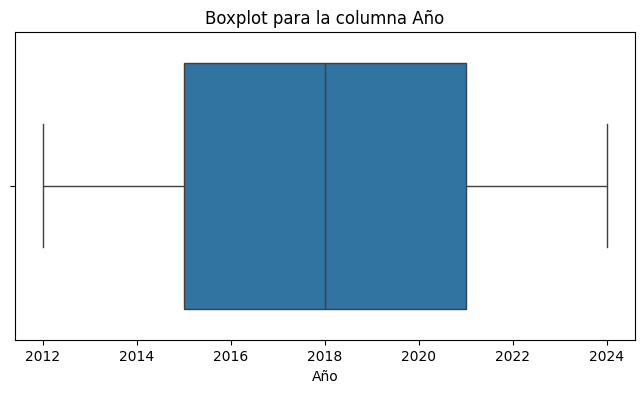

Cantidad de valores atípicos en la columna 'Mes': 0


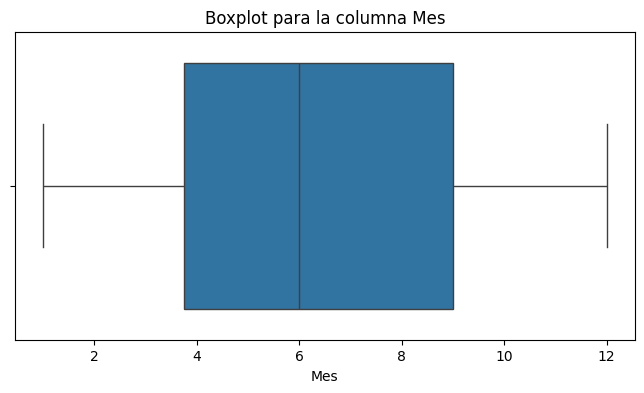

Cantidad de valores atípicos en la columna 'Total general': 0


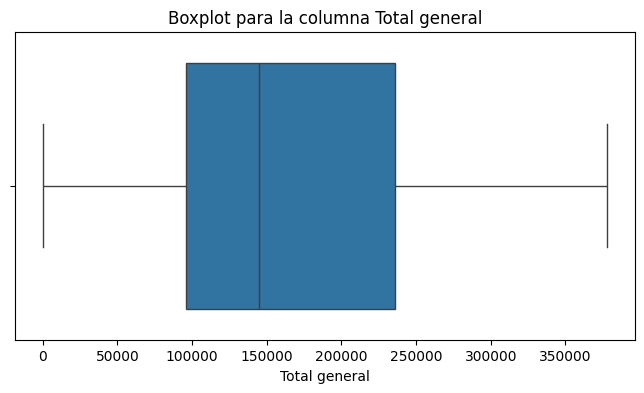


Resumen estadístico:
                Año         Mes  Total general
count   148.000000  148.000000     148.000000
mean   2017.837838    6.445946  159260.993243
std       3.587685    3.437060   95330.547558
min    2012.000000    1.000000     153.000000
25%    2015.000000    3.750000   95727.250000
50%    2018.000000    6.000000  144530.500000
75%    2021.000000    9.000000  235856.750000
max    2024.000000   12.000000  377682.000000

Tipos de datos:
 Año              int64
Mes              int64
Total general    int64
dtype: object


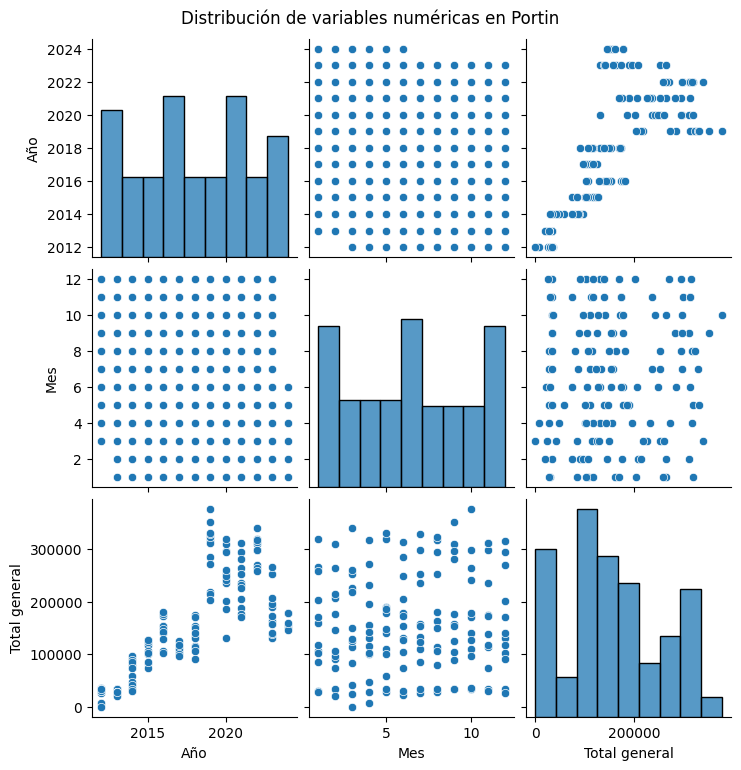

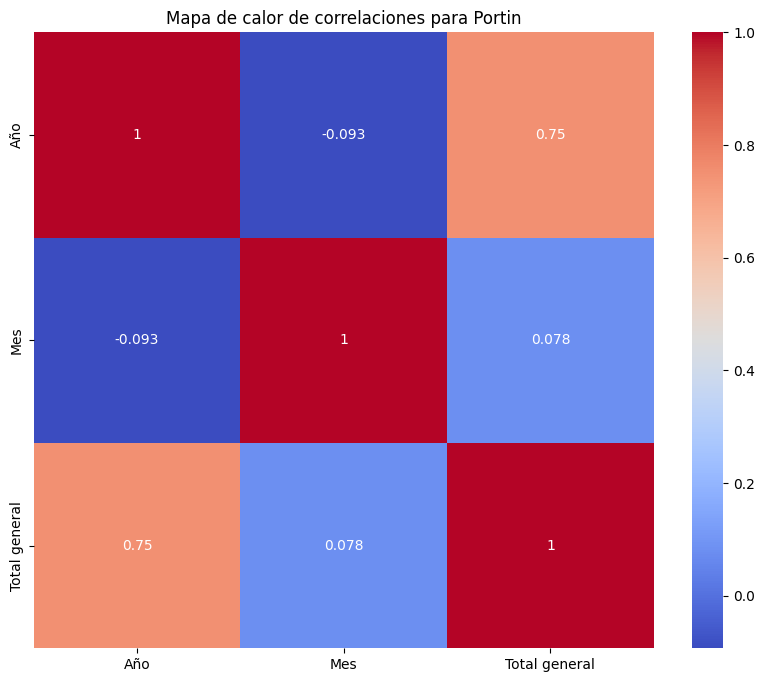

In [3]:
file_path = 'dataset_usado/Portabilidad.xlsx'
excel_data = pd.ExcelFile(file_path)
clean_and_explore(excel_data)


--- Análisis de la hoja: Fija_prov_tipo ---
Cantidad de valores faltantes antes de la limpieza: 0
Cantidad de registros duplicados antes de la limpieza: 0
Cantidad de valores faltantes eliminados: 0
Cantidad de valores atípicos en la columna 'Año': 0


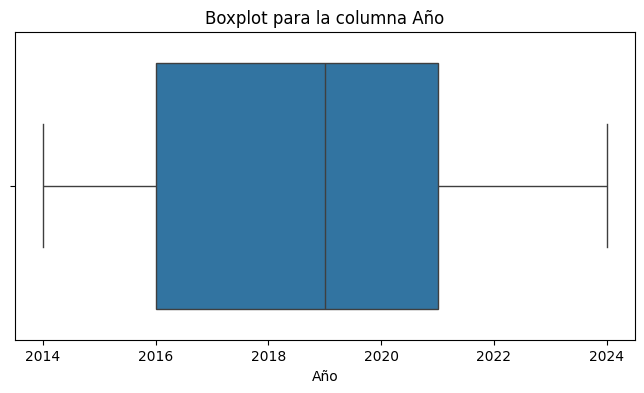

Cantidad de valores atípicos en la columna 'Trimestre': 0


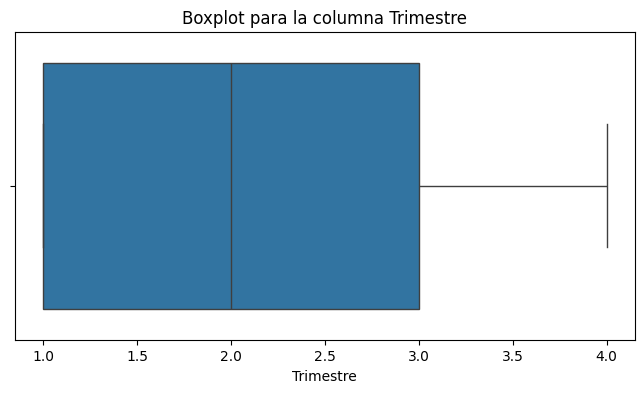

Cantidad de valores atípicos en la columna 'Accesos telefonía fija (total)': 168


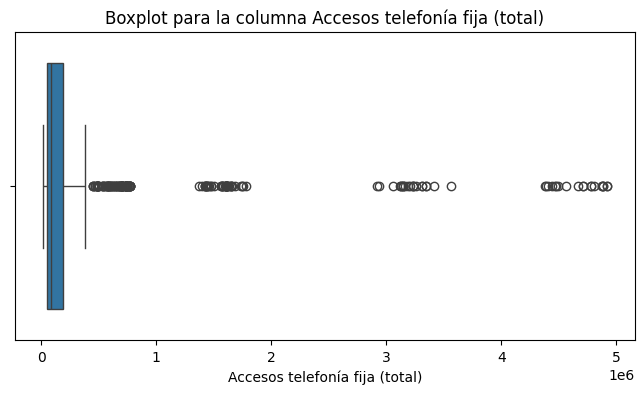

Cantidad de valores atípicos en la columna 'Accesos telefonía fija (hogares)': 168


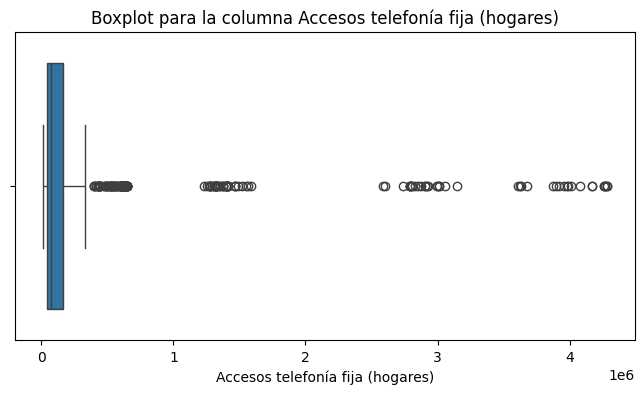

Cantidad de valores atípicos en la columna 'Accesos telefonía fija (comercial)': 176


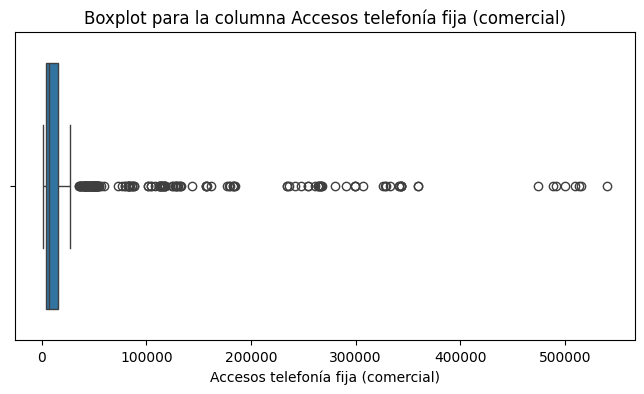

Cantidad de valores atípicos en la columna 'Accesos telefonía fija (gobierno)': 168


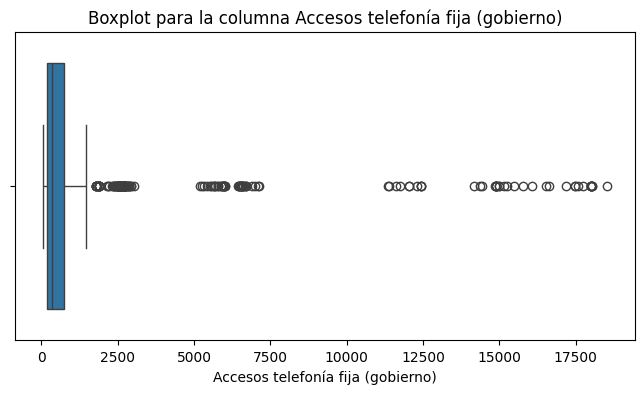

Cantidad de valores atípicos en la columna 'Accesos telefonía fija (otros)': 143


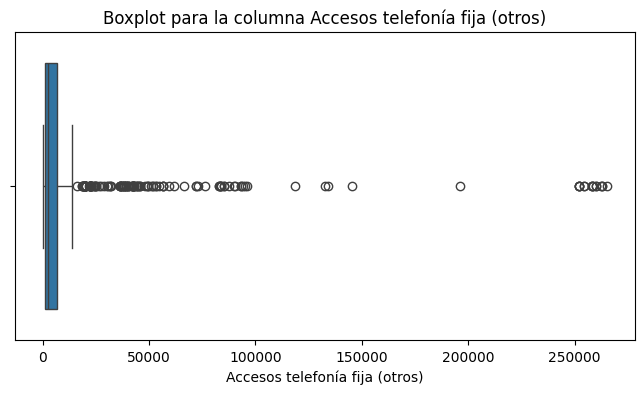


Resumen estadístico:
                Año    Trimestre  Accesos telefonía fija (total)  \
count  1008.000000  1008.000000                    1.008000e+03   
mean   2018.761905     2.452381                    3.567824e+05   
std       3.039439     1.117574                    8.245072e+05   
min    2014.000000     1.000000                    1.475200e+04   
25%    2016.000000     1.000000                    5.061250e+04   
50%    2019.000000     2.000000                    8.635550e+04   
75%    2021.000000     3.000000                    1.877165e+05   
max    2024.000000     4.000000                    4.916108e+06   

       Accesos telefonía fija (hogares)  Accesos telefonía fija (comercial)  \
count                      1.008000e+03                         1008.000000   
mean                       3.121301e+05                        30468.440476   
std                        7.188757e+05                        71893.667408   
min                        1.309300e+04                  

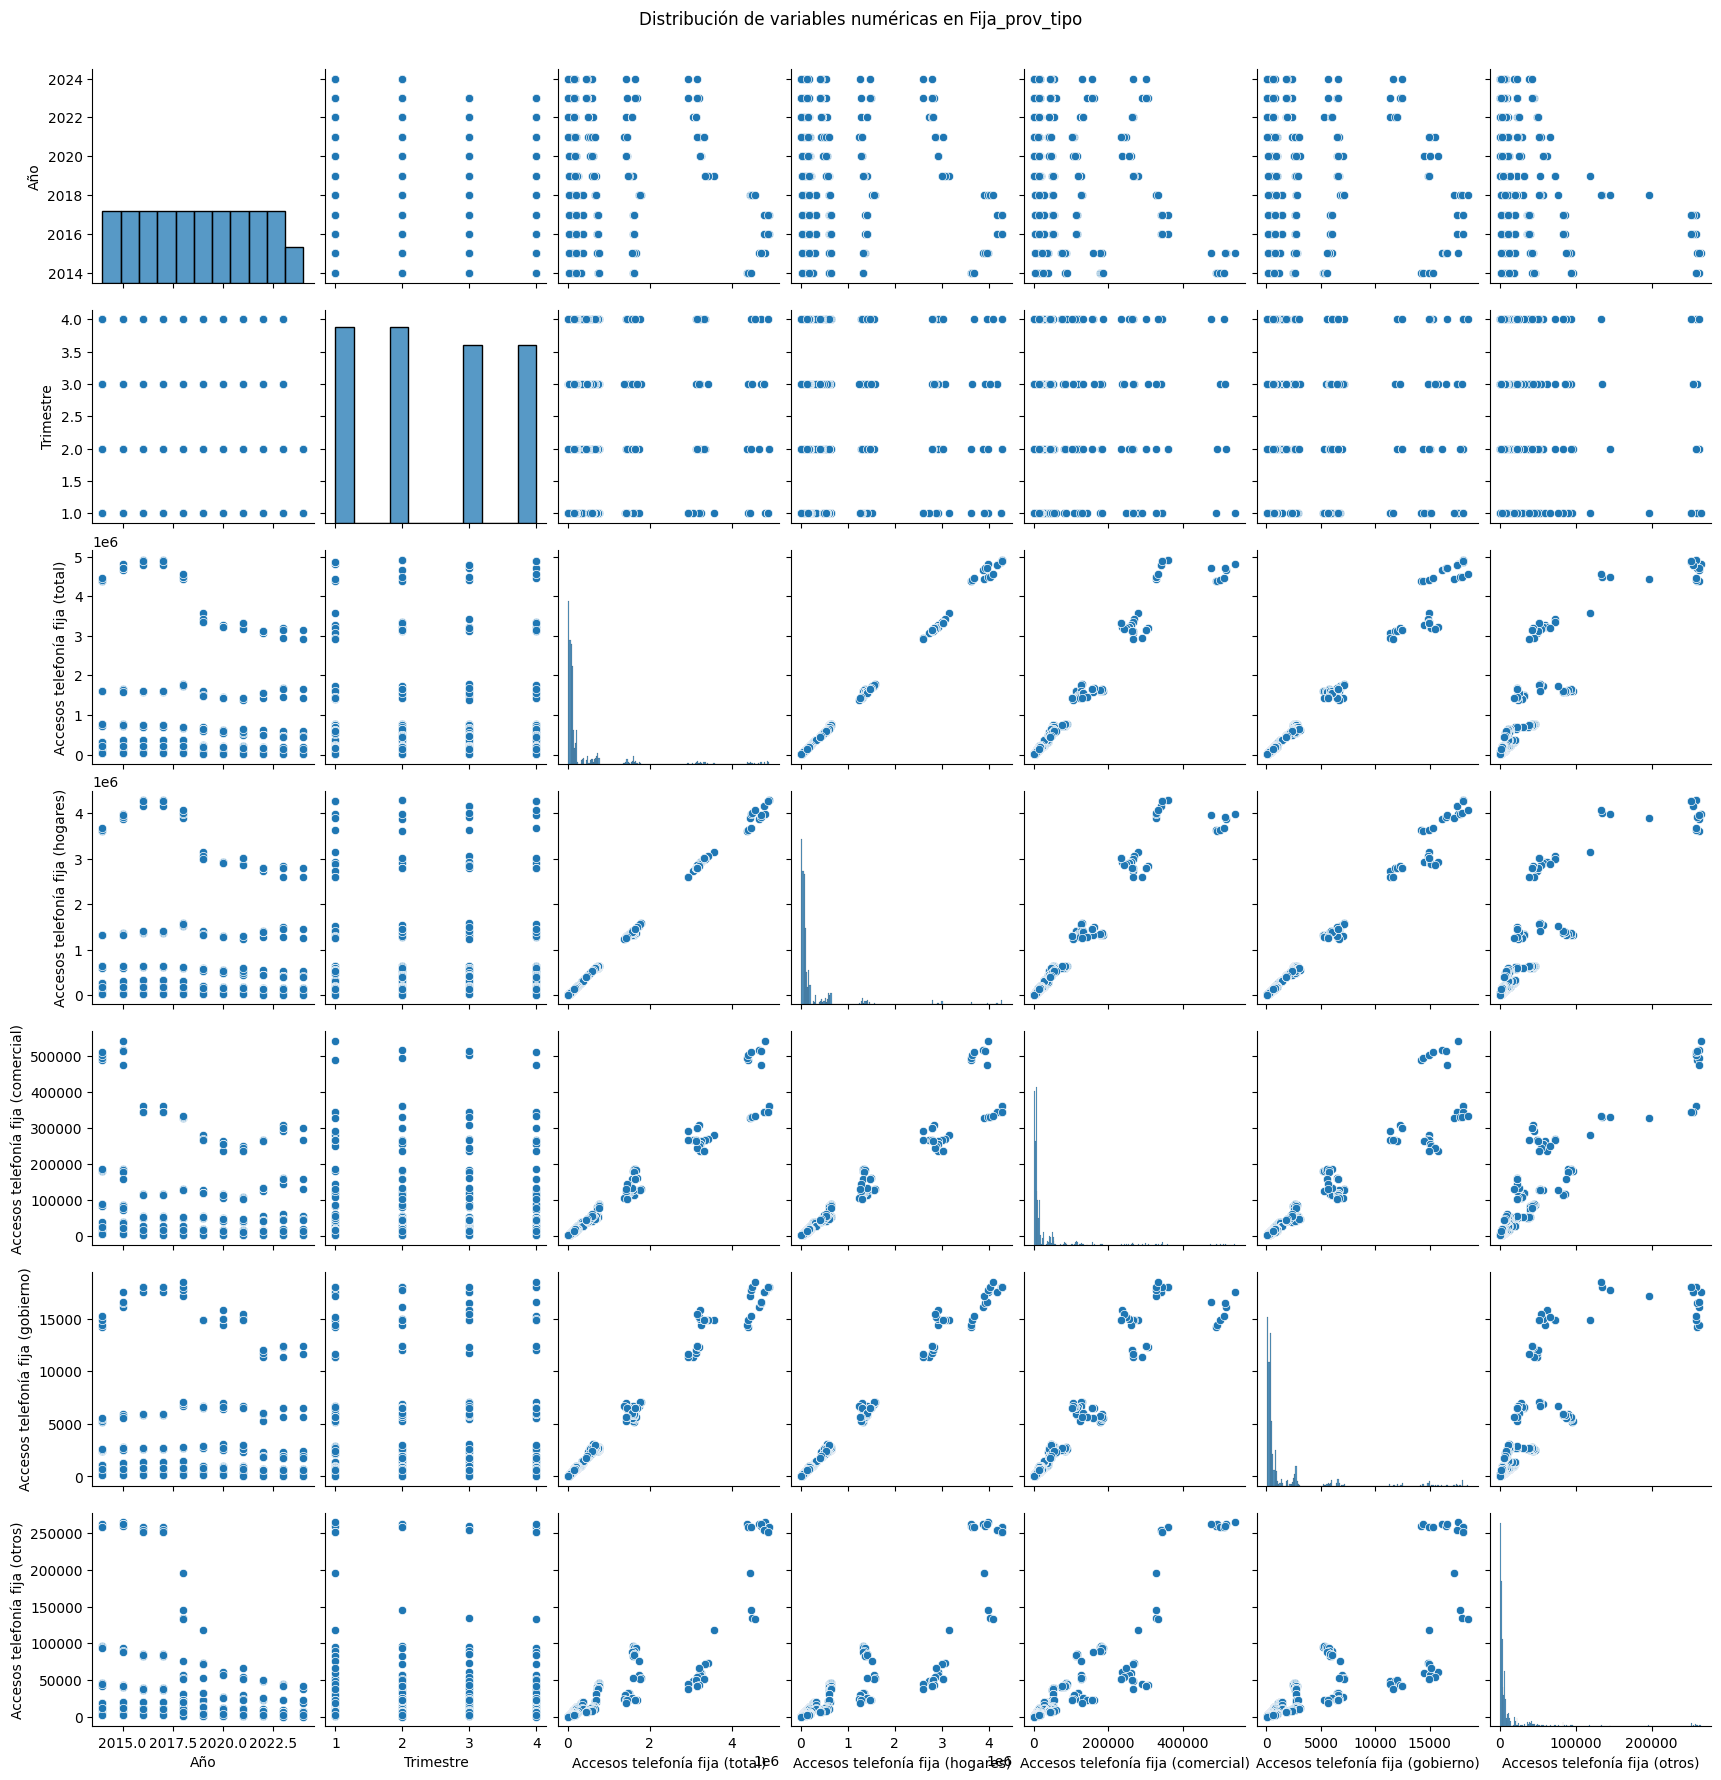

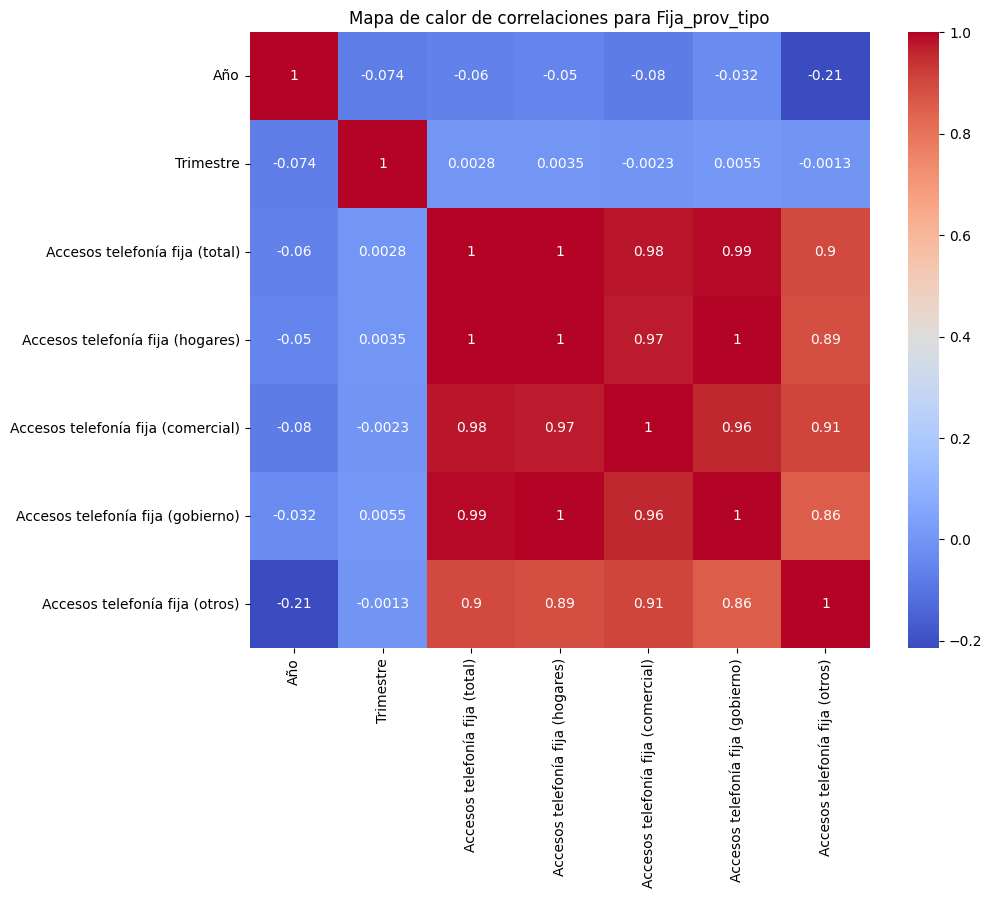

In [3]:
file_path = 'dataset_usado/telefonia_fija.xlsx'
excel_data = pd.ExcelFile(file_path)
clean_and_explore(excel_data)


--- Análisis de la hoja: Accesos_totales_TV ---
Cantidad de valores faltantes antes de la limpieza: 0
Cantidad de registros duplicados antes de la limpieza: 0
Cantidad de valores faltantes eliminados: 0
Cantidad de valores atípicos en la columna 'Año': 0


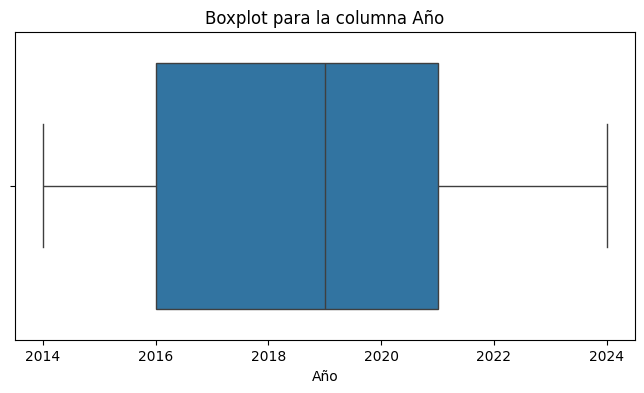

Cantidad de valores atípicos en la columna 'Trimestre': 0


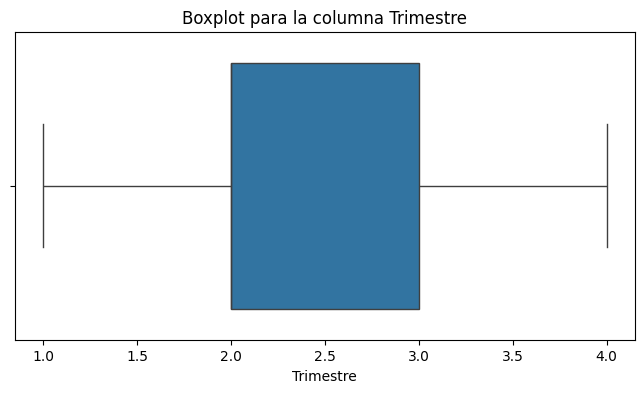

Cantidad de valores atípicos en la columna 'Accesos TV por suscripción': 0


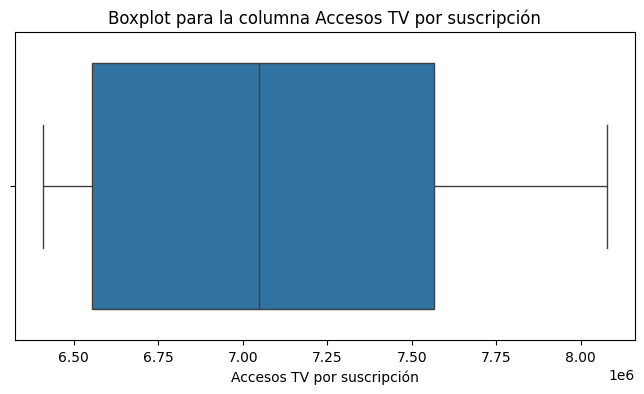

Cantidad de valores atípicos en la columna 'Accesos TV satelital': 0


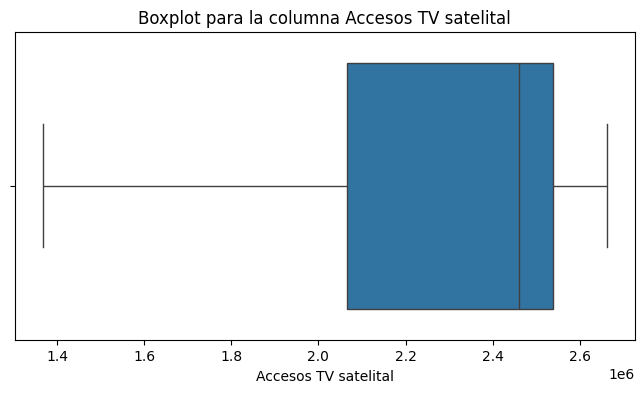


Resumen estadístico:
                Año  Trimestre  Accesos TV por suscripción  \
count    41.000000  41.000000                4.100000e+01   
mean   2018.878049   2.487805                7.086233e+06   
std       3.018237   1.120758                4.832267e+05   
min    2014.000000   1.000000                6.409504e+06   
25%    2016.000000   2.000000                6.553801e+06   
50%    2019.000000   2.000000                7.048709e+06   
75%    2021.000000   3.000000                7.564827e+06   
max    2024.000000   4.000000                8.076400e+06   

       Accesos TV satelital  
count          4.100000e+01  
mean           2.297208e+06  
std            3.572491e+05  
min            1.367489e+06  
25%            2.064699e+06  
50%            2.460177e+06  
75%            2.537610e+06  
max            2.662031e+06  

Tipos de datos:
 Año                           int64
Trimestre                     int64
Accesos TV por suscripción    int64
Accesos TV satelital          i

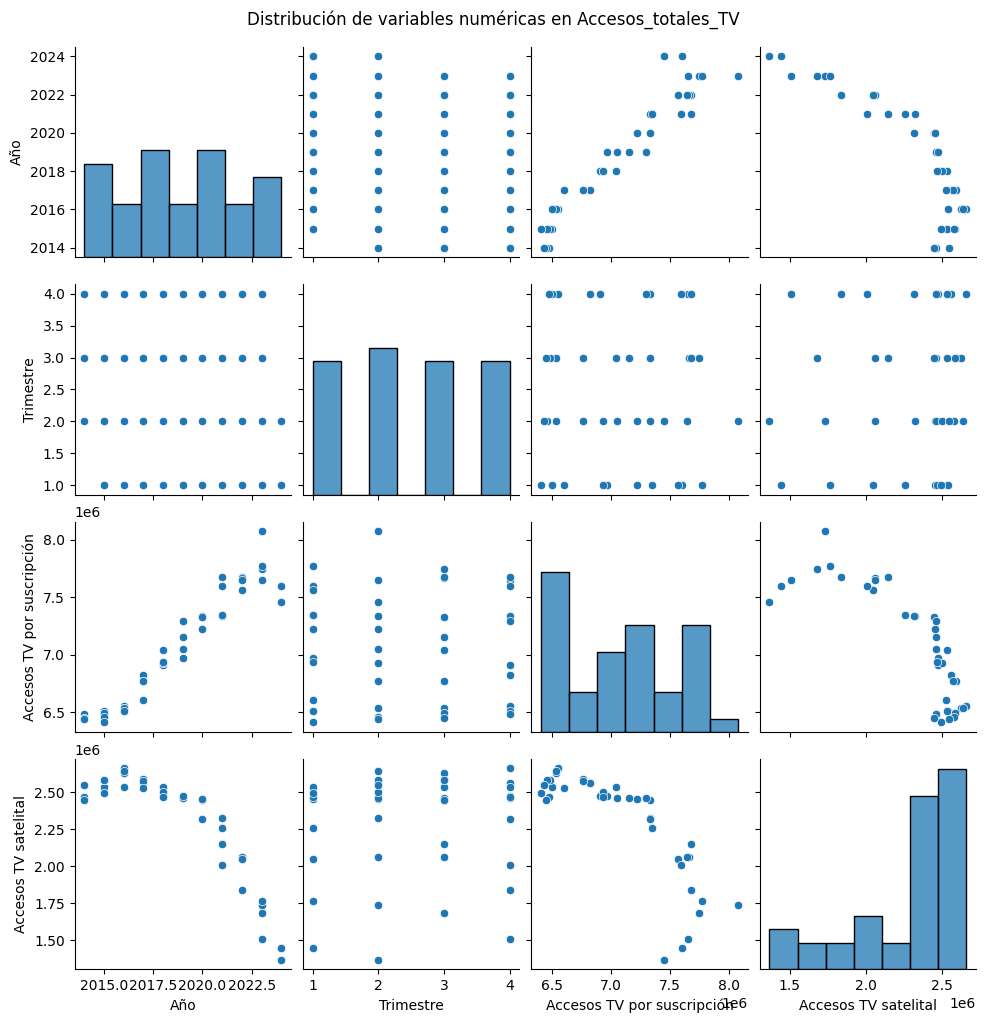

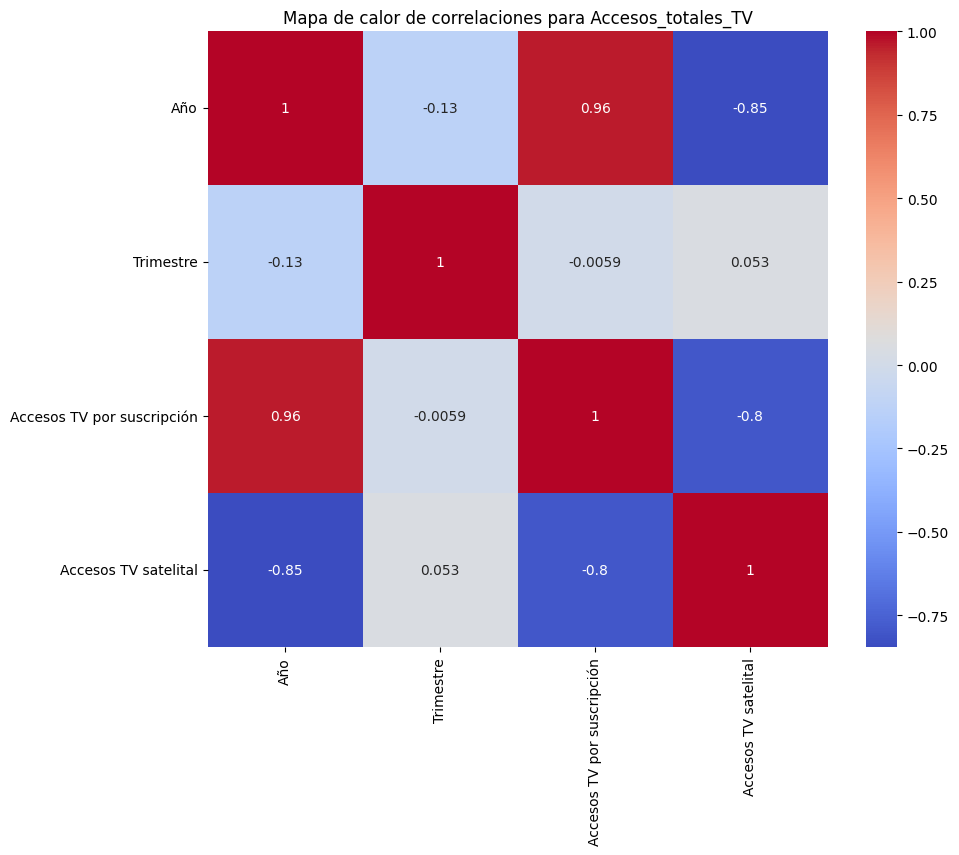

In [4]:
file_path = 'dataset_usado/Television.xlsx'
excel_data = pd.ExcelFile(file_path)
clean_and_explore(excel_data)